# PRABAL GHOSH
## Deep Learning Lab =  Sequence to Sequence (seq2seq) variable length and Attention and Transformer

You must submit a notebook with execution traces and perfectly written corresponding to the course on Seq2Seq, Seq2Seq with Attention and Transformer architectures. This notebook will identify at least 5 sections:
- Introduction: presentation of the problem and how to proceed
- Data pre-processing
- Seq2Seq architecture
- Seq2Seq architecture with Attention (specify which attention model you used)
- Transformer-based architecture
- Use of a model from huggingface.co (transfer learning) to address the same problem (optional)
- Conclusion: comparison of approaches and personal remarks

Submit also a pdf version of your notebook

# Some important links for Sequence to Sequence (seq2seq) variable length and Attention and Transformer


## <font color = green> **Data is dowlnloaded from the following link** </font>  
[https://www.manythings.org/anki/](https://www.manythings.org/anki/)(Tab-delimited Bilingual Sentence Pairs)

**The following tutorial is followed to understand the Sequence to Sequence**

- "https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html" (basics+attention part)
- "https://towardsdatascience.com/classic-seq2seq-model-vs-seq2seq-model-with-attention-31527c77b28a"
- "https://wikidocs.net/178419"
- "https://www.jeremyjordan.me/attention/"
- "https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/"
- "https://www.tensorflow.org/text/tutorials/transformer"
- "https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html" (A ten-minute introduction to sequence-to-sequence learning in Keras)

**The following youtube videos are good to understand the concepts**
- "https://www.youtube.com/watch?v=XfpMkf4rD6E"
- "https://www.youtube.com/watch?v=RRP0czWtOeM&list=PLQflnv_s49v-4aH-xFcTykTpcyWSY4Tww&index=5"
- "https://www.youtube.com/watch?v=7gHqxK1o7MU"

# Normal Sequence to Sequence (seq2seq)

## import libraries

<img  src="https://www.jeremyjordan.me/content/images/size/w1600/2023/02/path-length-1-2.png" />



<video controls src="https://lena-voita.github.io/resources/lectures/seq2seq/general/seq2seq_training_with_target.mp4" />  

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd


In [2]:
import tensorflow as tf
import keras

In [3]:
import unicodedata
import re
import os
import io
import time

In [4]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

## Data Preprocessing

The data is available here: http://www.manythings.org/anki/.
They consist of a set of pairs in the following format:

  `hi .`  `hola .`

There are a variety of languages available, English-Spanish data will be used.

The processing of the data will consist of the following steps:

1. Removal of special characters
1. adding a start or end token to each sentence.
1. Creating the vectorizer for each of the two languages

**Limit the number of examples is 5000 for faster processing**


In [6]:
from google.colab import files
uploaded = files.upload()


Saving fra.txt to fra.txt


In [8]:
import pandas as pd  # Import pandas library for data manipulation
import re  # Import re library for regular expressions
import unicodedata  # Import unicodedata library for handling Unicode characters

# Load dataset from file
# dataset = 'C:/Users/praba\Documents/GitHub/deep_learning_uca_2/spa-eng/spa.txt'

dataset = 'fra.txt'

data = pd.read_table(dataset)  # Read data from file into a DataFrame

# Extract source (X) and target (y) sentences from the DataFrame
X = data.iloc[:, 0]  # Extract the first column as source sentences
y = data.iloc[:, 1]  # Extract the second column as target sentences

# Limit the number of examples for faster processing
X = X[:5000]  # Limit the number of source sentences to 10000
y = y[:5000]  # Limit the number of target sentences to 10000

# Define a function to preprocess a sentence
def step1(sent):
    # Function to preprocess a sentence
    def unicode_to_ascii(s):
        # Normalize Unicode characters and remove accents
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

    # Convert the sentence to lowercase and remove leading/trailing whitespaces
    sent = unicode_to_ascii(sent.lower().strip())

    # Add spaces between words and punctuation
    sent = re.sub(r"([?.!,¿])", r" \1 ", sent)
    sent = re.sub(r'[" "]+', " ", sent)

    # Replace everything except letters, punctuation, and some special characters with spaces
    sent = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sent)

    # Add <start> and <end> tokens to the sentence
    return '<start> ' + sent.strip() + ' <end>'

# Apply the preprocessing function to each source and target sentence
X_processed = X.apply(step1)  # Preprocess source sentences
y_processed = y.apply(step1)  # Preprocess target sentences

# Print the first few preprocessed sentences to check
print(X_processed.head())
print(y_processed.head())


0    <start> go . <end>
1    <start> go . <end>
2    <start> go . <end>
3    <start> hi . <end>
4    <start> hi . <end>
Name: Go., dtype: object
0      <start> marche . <end>
1    <start> en route ! <end>
2       <start> bouge ! <end>
3       <start> salut ! <end>
4       <start> salut . <end>
Name: Va !, dtype: object


In [9]:
# data.iloc[:500, [0, 1]]

In [10]:
# data.iloc[:, 0]

In [11]:
english_sentences = X_processed_array = np.array(X_processed)
spanish_sentences = y_processed_array = np.array(y_processed)
X_processed_array.shape, y_processed.shape

((5000,), (5000,))

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed_array, y_processed_array, test_size=0.33, random_state=42)


In [13]:
y_processed_array[1]

'<start> en route ! <end>'

In [14]:
# X_train

In [15]:
# y_train

In [16]:
# Search vocabulary and max_length for each language
def voc(lang):
    # a list of sentences in the same language
    lengths = [len(txt.split()) for txt in lang]
    vocab = set([w for txt in lang for w in txt.split()])

    return max(lengths), list(vocab), len(vocab)+2 # for padding and OOV

max_length_spanish, vocab_spanish, vocab_size_spanish = voc(y_processed_array)
max_length_english, vocab_english, vocab_size_english = voc(X_processed_array)

In [17]:
max_length_spanish,max_length_english

(14, 7)

In [18]:
vocab_size_english

1093

In [19]:
# Build vectorizer layer
english_vectorizer = layers.TextVectorization(standardize=None, output_mode='int',
                                              vocabulary=vocab_english,
                                              name="English_vect")
# On peut connaitre le vocabulaire par english_vectorizer.get_vocabulary()

# Do the same for spanish
spanish_vectorizer = layers.TextVectorization(standardize=None, output_mode='int',
                                              vocabulary=vocab_spanish,
                                              name="Spanish_vect")

In [20]:
BATCH_SIZE = 32
embedding_dim = 100
latent_dim = 64
dropout=0.2


## basic model

**Encoder part**

In [21]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,),name="spanish_input")
# encoder_inputs = Input(shape=(None,),dtype=tf.string, name="spanish_input")

# encoder_vectorizer = spanish_vectorizer(encoder_inputs)
# layer_embedding = layers.Embedding(vocab_size_spanish, embedding_dim, name="sp_embedding")

layer_embedding = layers.Embedding(vocab_size_spanish, embedding_dim, name="sp_embedding")
embedding_layer_final = layer_embedding(encoder_inputs)
layer_lstm = LSTM(latent_dim, return_sequences=False, return_state=True)
# _, enc_state_h, enc_state_c = LSTM(latent_dim,  return_sequences=False,return_state=True,
#                                    dropout=dropout, recurrent_dropout=dropout, name="encoder")(embedding_layer_final)

enc_state_output, enc_state_h, enc_state_c = layer_lstm(embedding_layer_final)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [enc_state_h, enc_state_c]



**Decoder part**

In [22]:
# decoder_inputs = Input(shape=(None,), dtype=tf.int32, name="english_teacher")
decoder_inputs = Input(shape=(None,), name="english_teacher")

layer_embedding_decoder = layers.Embedding(vocab_size_english, embedding_dim
                     ,name="english_embedding")
x =layer_embedding_decoder(decoder_inputs)
decoder_lstm = layers.LSTM(latent_dim, return_sequences=True, return_state=True,
#                            dropout=dropout, recurrent_dropout=dropout, name="decoder1")
                          )

decoder_outputs, _, _ = decoder_lstm(x, initial_state=encoder_states)
decoder_dense = layers.Dense(vocab_size_english, activation='softmax')
decoder_outputs_final = decoder_dense(decoder_outputs)


In [23]:
decoder_lstm.output_shape


[(None, None, 64), (None, 64), (None, 64)]

In [24]:
# Define the model
model1 = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)

In [25]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 spanish_input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 english_teacher (InputLaye  [(None, None)]               0         []                            
 r)                                                                                               
                                                                                                  
 sp_embedding (Embedding)    (None, None, 100)            215400    ['spanish_input[0][0]']       
                                                                                                  
 english_embedding (Embeddi  (None, None, 100)            109300    ['english_teacher[0][0]'] 

In [26]:
import unicodedata
import re
import numpy as np
import pandas as pd
import os
import io
import time

import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [27]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


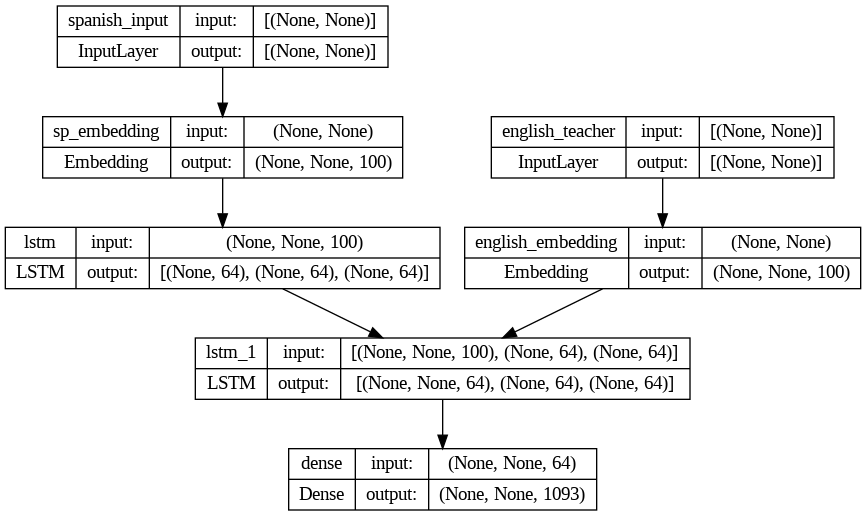

In [28]:
from tensorflow.keras.utils import plot_model

plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [29]:
spanish_embedded_data = spanish_vectorizer(y_processed_array)


In [30]:
# Prepare training data with teacher forcing
# decoder_input_data is a 2D array of shape (None, None) containing a tokenization of the English sentences.
# decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t] will be the same as decoder_input_data[:, t-1].

english_teacher_enc = english_vectorizer(X_processed_array) #.numpy() # Teacher
english_target_enc = np.zeros_like(english_teacher_enc)
english_target_enc[:,:-1] = english_teacher_enc[:,1:] # To predict
english_target_enc.shape

(5000, 7)

In [31]:
# english_teacher_enc

In [32]:
# Configure the model and start training
# Stop training with early stopping with patience of 20
callbacks_list = [EarlyStopping(monitor='loss', mode='min', min_delta=0.000001,
                                patience=3, restore_best_weights=True, verbose=1,
                                )]


# history = model1.fit([y_processed_array, english_teacher_enc], english_target_enc,
#                     validation_split=0.1,
#                     epochs=5, batch_size=BATCH_SIZE,
#                     callbacks=callbacks_list,
#                     verbose=1)



history = model1.fit([spanish_embedded_data, english_teacher_enc], english_target_enc,
                    validation_split=0.1,
                    epochs=50, batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
                    verbose=1)


Epoch 1/50
141/141 [==============================] - 6s 23ms/step - loss: 3.6679 - accuracy: 0.3667 - val_loss: 3.3404 - val_accuracy: 0.3137
Epoch 2/50
141/141 [==============================] - 2s 15ms/step - loss: 2.4213 - accuracy: 0.5907 - val_loss: 2.8507 - val_accuracy: 0.5220
Epoch 3/50
141/141 [==============================] - 2s 15ms/step - loss: 2.0767 - accuracy: 0.6502 - val_loss: 2.6848 - val_accuracy: 0.5194
Epoch 4/50
141/141 [==============================] - 2s 15ms/step - loss: 1.9108 - accuracy: 0.6677 - val_loss: 2.5808 - val_accuracy: 0.5257
Epoch 5/50
141/141 [==============================] - 2s 15ms/step - loss: 1.7967 - accuracy: 0.6771 - val_loss: 2.5131 - val_accuracy: 0.5257
Epoch 6/50
141/141 [==============================] - 3s 19ms/step - loss: 1.7270 - accuracy: 0.6821 - val_loss: 2.4663 - val_accuracy: 0.5277
Epoch 7/50
141/141 [==============================] - 2s 16ms/step - loss: 1.6768 - accuracy: 0.6855 - val_loss: 2.4334 - val_accuracy: 0.5317

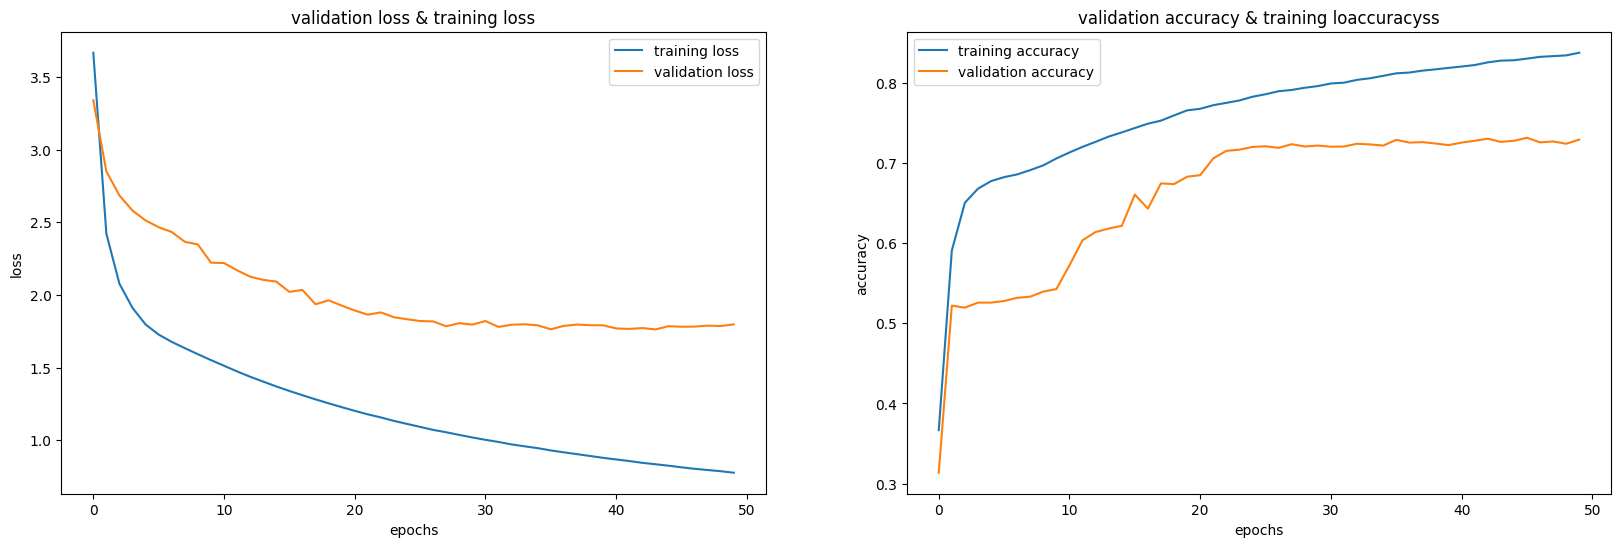

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
# Plot the first subplot  loss)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("validation loss & training loss")
plt.xlabel("epochs")
plt.ylabel("loss")
leg = plt.legend(["training loss", "validation loss"],loc ="upper right");

# Plot the second subplot ( accuracy)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("validation accuracy & training loaccuracyss")
plt.xlabel("epochs")
plt.ylabel("accuracy")
leg = plt.legend(["training accuracy", "validation accuracy"],loc ="upper left");

plt.show()


### prediction

In [34]:
y_pred=model1.predict([spanish_embedded_data, english_teacher_enc])

157/157 [==============================] - 1s 4ms/step


In [35]:
y_pred.shape

(5000, 7, 1093)

In [36]:
# y_pred[1]

In [37]:
# Pour décoder, il faut transformer un entier en mot.
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n :
            return word
    return None


In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Now you can use the Tokenizer class
# tokenizer = Tokenizer()

def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer



In [39]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame

# Selecting data from the first two columns
first_two_columns_data = data.iloc[:, :2]

# Convert the selected data into a NumPy array
fra_eng = np.array(first_two_columns_data.values)

# print("Array Data:")
# print(array_data)


In [40]:
eng_tokenizer = tokenization(fra_eng[:,0])

In [41]:
def get_word(index, tokenizer):
    word = None
    for word, idx in tokenizer.word_index.items():
        if idx == index:
            return word
    return word


In [42]:
# preds_text = []

# for i in y_pred:
#     temp = []
#     for j in range(len(i)):
#         t = get_word(i[j], eng_tokenizer)
#         if j>0:
#             if (t ==get_word(i[j-1],eng_tokenizer ) or (t ==  None)):
#                 temp.append("")
#             else:
#                 temp.append(t)
#         else:
#             if(t == None):
#                 temp.append("")
#             else:
#                 temp.append(t)
#     preds_text.append("".join(temp))


In [43]:
# pred_df = pd.DataFrame({"actual":data.iloc[:1000, 0], "predicted": preds_text})

##  basic model -2

**ENCODER**

In [44]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,))
layer_embedding = layers.Embedding(vocab_size_spanish, embedding_dim)
embedding_layer_final = layer_embedding(encoder_inputs)

encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(embedding_layer_final)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]



**DECODER**

In [45]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.

layer_embedding_decoder = layers.Embedding(vocab_size_english, embedding_dim)
x =layer_embedding_decoder(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(x,
                                     initial_state=encoder_states)
decoder_dense = Dense(vocab_size_english, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model_encoder_training = Model([encoder_inputs, decoder_inputs], decoder_outputs, name="model_encoder_training")

In [46]:
model_encoder_training.summary()

Model: "model_encoder_training"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 100)            215400    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 100)            109300    ['input_2[0][0]']             
                                                                             

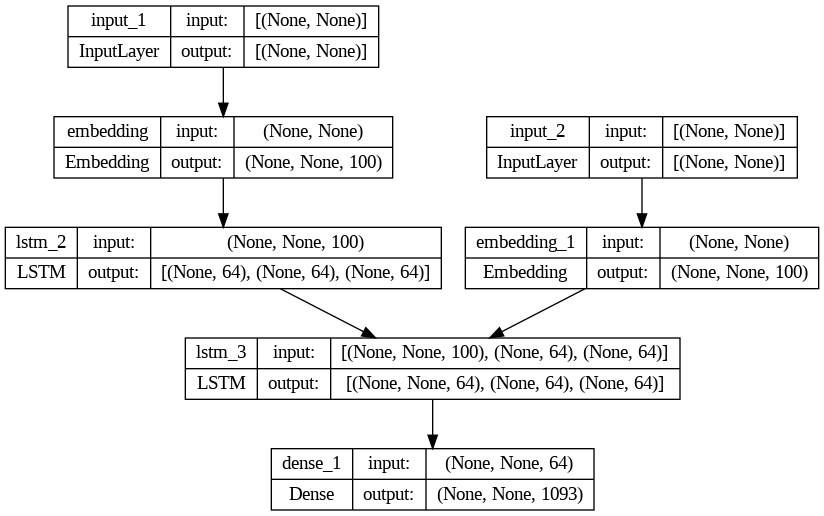

In [47]:
from tensorflow.keras.utils import plot_model

plot_model(model_encoder_training, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

In [48]:
# Run training
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy')


model_encoder_training.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])



In [49]:
# spanish_embedded_data_test = spanish_vectorizer(y_test)
# english_teacher_enc_test = english_vectorizer(X_test)

In [50]:
# Configure the model and start training
# Stop training with early stopping with patience of 20
callbacks_list = [EarlyStopping(monitor='loss', mode='min', min_delta=0.000001,
                                patience=3, restore_best_weights=True, verbose=1,
                                )]


# history = model1.fit([y_processed_array, english_teacher_enc], english_target_enc,
#                     validation_split=0.1,
#                     epochs=5, batch_size=BATCH_SIZE,
#                     callbacks=callbacks_list,
#                     verbose=1)



history = model_encoder_training.fit([spanish_embedded_data, english_teacher_enc], english_target_enc,
                    validation_split=0.1,
                    epochs=50, batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
                    verbose=1)

Epoch 1/50
141/141 [==============================] - 6s 23ms/step - loss: 3.6493 - accuracy: 0.3739 - val_loss: 3.1938 - val_accuracy: 0.3386
Epoch 2/50
141/141 [==============================] - 2s 15ms/step - loss: 2.4137 - accuracy: 0.5857 - val_loss: 2.8558 - val_accuracy: 0.5129
Epoch 3/50
141/141 [==============================] - 2s 15ms/step - loss: 2.0695 - accuracy: 0.6533 - val_loss: 2.6656 - val_accuracy: 0.5197
Epoch 4/50
141/141 [==============================] - 2s 15ms/step - loss: 1.8989 - accuracy: 0.6680 - val_loss: 2.5814 - val_accuracy: 0.5274
Epoch 5/50
141/141 [==============================] - 2s 16ms/step - loss: 1.7881 - accuracy: 0.6800 - val_loss: 2.4668 - val_accuracy: 0.5291
Epoch 6/50
141/141 [==============================] - 2s 18ms/step - loss: 1.7159 - accuracy: 0.6834 - val_loss: 2.4147 - val_accuracy: 0.5289
Epoch 7/50
141/141 [==============================] - 2s 15ms/step - loss: 1.6626 - accuracy: 0.6868 - val_loss: 2.3474 - val_accuracy: 0.5349

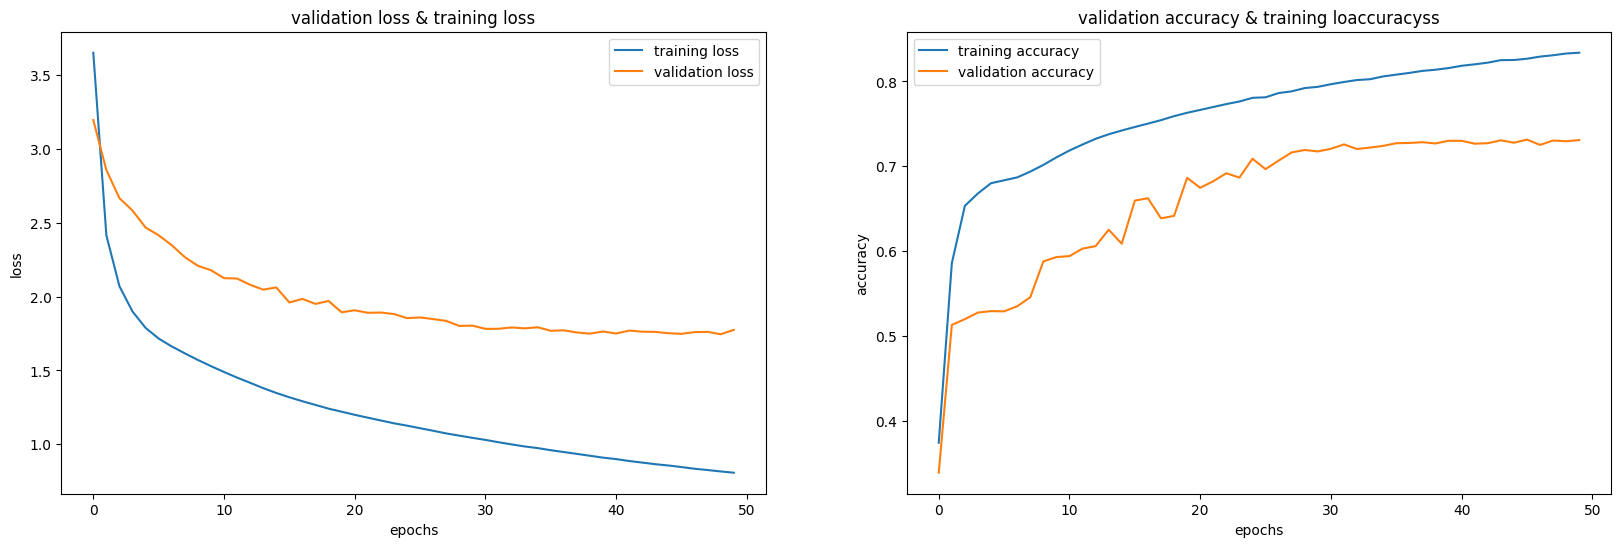

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
# Plot the first subplot  loss)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("validation loss & training loss")
plt.xlabel("epochs")
plt.ylabel("loss")
leg = plt.legend(["training loss", "validation loss"],loc ="upper right");

# Plot the second subplot ( accuracy)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("validation accuracy & training loaccuracyss")
plt.xlabel("epochs")
plt.ylabel("accuracy")
leg = plt.legend(["training accuracy", "validation accuracy"],loc ="upper left");

plt.show()


## Inference

In [52]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

layer_embedding_decoder_inf = layer_embedding_decoder(decoder_inputs)
decoder_outputs, state_h, state_c = decoder_lstm(
    layer_embedding_decoder_inf , initial_state=decoder_states_inputs)


decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [53]:
# def decode_sequence(input_seq):
#     # Encode the input as state vectors.
#     states_value = encoder_model.predict(input_seq)
#     # Iterate over decoded sentence. Target_seq is the input of the decoder
#     target_seq = np.zeros((len(input_seq), 1))
#     target_seq[:, 0] = word2token["<start>"]
#     print(target_seq.shape)
#     output_sequence = [] # Output_sequence is the output of the decoder
#     for _ in range(vocab_size_english):   # vocab_size_english = max_output_length
#         output_value, h, c = decoder_model.predict( [target_seq] + states_value)
#         # Update the target sequence (of length 1) and state
#         target_seq[:, 0] = decode(output_value)
#         states_value = [h, c]
#         # extend output sequence
#         output_sequence += [target_seq]
#     return output_sequence # eventually format i

In [54]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Initialize target sequence
    target_seq = np.zeros((input_seq.shape[0], 1))  # Assuming input_seq is a NumPy array

    # Initialize output sequence
    output_sequence = []

    for _ in range(vocab_size_english):  # Assuming max_output_length is defined somewhere
        output_value, h, c = decoder_model.predict([target_seq] + states_value)

        # Update the target sequence
        sampled_token_index = np.argmax(output_value, axis=-1)
        target_seq = sampled_token_index.reshape(-1, 1)

        # Update states
        states_value = [h, c]

        # Append the predicted token to the output sequence
        output_sequence.append(sampled_token_index)

    return np.array(output_sequence)  # Convert the output sequence to a NumPy array




In [55]:
# spanish_embedded_data is input sequence
decoded_sequence = decode_sequence(spanish_embedded_data)

157/157 [==============================] - 0s 1ms/step


In [56]:
decoded_sequence.shape

(1093, 5000, 1)

In [57]:
# from keras.models import Model
# from keras.layers import Input, LSTM, Dense, Embedding

# # Define input shape and parameters
# # vocab_size_spanish = ...
# BATCH_SIZE = 32
# embedding_dim = 100
# latent_dim = 64
# dropout=0.2


# # Encoder
# encoder_inputs = Input(shape=(None,), dtype=tf.int32, name="spanish_input")
# encoder_embedding = Embedding(vocab_size_spanish, embedding_dim, name="sp_embedding")(encoder_inputs)
# encoder_lstm = LSTM(latent_dim, return_sequences=False, return_state=True, dropout=dropout, recurrent_dropout=dropout, name="encoder")
# _, enc_state_h, enc_state_c = encoder_lstm(encoder_embedding)
# encoder_states = [enc_state_h, enc_state_c]

# # Define encoder model
# encoder_model = Model(encoder_inputs, encoder_states)

# # Decoder
# decoder_inputs = Input(shape=(None,), dtype=tf.int32, name="english_teacher")
# decoder_embedding = Embedding(vocab_size_english, embedding_dim, name="english_embedding")(decoder_inputs)
# decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=dropout, recurrent_dropout=dropout, name="decoder")
# decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
# decoder_dense = Dense(vocab_size_english, activation='softmax')
# decoder_outputs_final = decoder_dense(decoder_outputs)

# # Define the model
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)


# Sequence to Sequence Attention

<img  src="https://lena-voita.github.io/resources/lectures/seq2seq/attention/general_scheme-min.png" />


In [58]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import tensorflow as tf

# Define an input sequence and process it.
# encoder_inputs = Input(shape=(1,), dtype=tf.string, name="spanish_input")
encoder_inputs = Input(shape=(None,), name="spanish_input")

# encoder_vectorizer = spanish_vectorizer(encoder_inputs)

# enc = layers.Embedding(vocab_size_spanish, embedding_dim, name="sp_embedding")(encoder_vectorizer)

layer_embedding = layers.Embedding(vocab_size_spanish, embedding_dim)
embedding_layer_final = layer_embedding(encoder_inputs)

enc_state_ouput, enc_state_h, enc_state_c = LSTM(latent_dim,  return_sequences=True, return_state=True,
                                   dropout=dropout, recurrent_dropout=dropout, name="encoder")(embedding_layer_final)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [enc_state_h, enc_state_c]





decoder_inputs = Input(shape=(None,), name="english_teacher")
# decoder_inputs = Input(shape=(None,), dtype=tf.int32, name="english_teacher")
x = layers.Embedding(vocab_size_english, embedding_dim, name="english_embedding")(decoder_inputs)



# Adding the Attention mechanism

decoder_lstm = layers.LSTM(latent_dim, return_sequences=True, return_state=True,
                           dropout=dropout, recurrent_dropout=dropout, name="Decoder")
decoder_outputs,decoder_state_h, decoder_state_c = decoder_lstm(x, initial_state=encoder_states)

attention = tf.keras.layers.Attention()([decoder_outputs, enc_state_ouput])  # Using the decoder input and encoder output for attention
decoder_combined_context = layers.concatenate([attention, decoder_outputs], name="Luong_Attention")

decoder_dense = layers.Dense(vocab_size_english, activation='softmax')
decoder_outputs_final = decoder_dense(attention)

# Define the model
model2 = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)


In [59]:
# x

In [60]:
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 spanish_input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 english_teacher (InputLaye  [(None, None)]               0         []                            
 r)                                                                                               
                                                                                                  
 embedding_2 (Embedding)     (None, None, 100)            215400    ['spanish_input[0][0]']       
                                                                                                  
 english_embedding (Embeddi  (None, None, 100)            109300    ['english_teacher[0][0]'

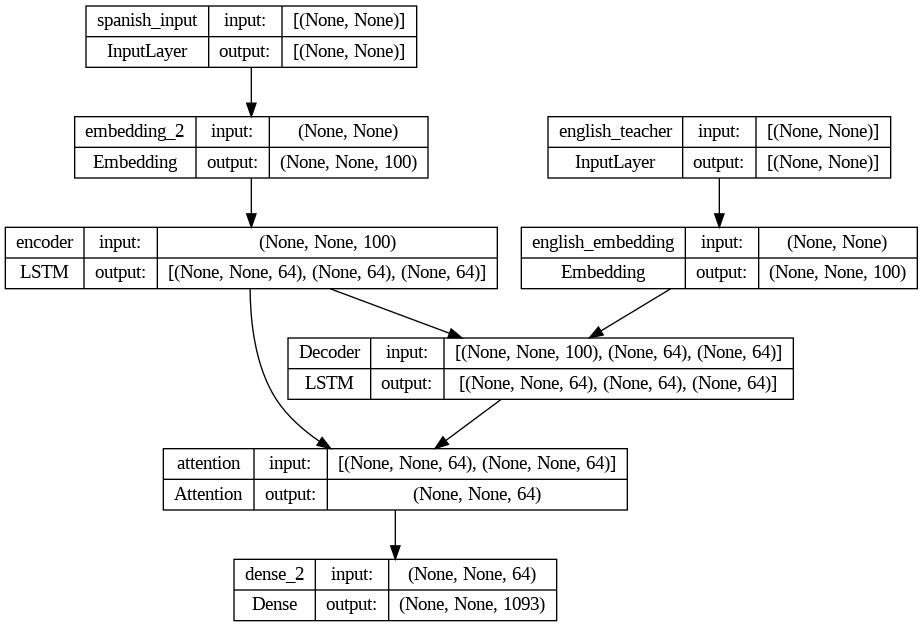

In [61]:
from tensorflow.keras.utils import plot_model

plot_model(model2, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [62]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [63]:
# Prepare training data with teacher forcing
# decoder_input_data is a 2D array of shape (None, None) containing a tokenization of the English sentences.
# decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t] will be the same as decoder_input_data[:, t-1].

english_teacher_enc = english_vectorizer(X_processed_array) #.numpy() # Teacher
english_target_enc = np.zeros_like(english_teacher_enc)
english_target_enc[:,:-1] = english_teacher_enc[:,1:] # To predict
english_target_enc.shape

(5000, 7)

In [64]:
# Configure the model and start training
# Stop training with early stopping with patience of 20
callbacks_list = [EarlyStopping(monitor='loss', mode='min', min_delta=0.000001,
                                patience=5, restore_best_weights=True, verbose=1,
                                )]


# history = model2.fit([y_processed_array, english_teacher_enc], english_target_enc,
#                     validation_split=0.1,
#                     epochs=10, batch_size=BATCH_SIZE,
#                     callbacks=callbacks_list,
#                     verbose=1)




history = model2.fit([spanish_embedded_data, english_teacher_enc], english_target_enc,
                    validation_split=0.1,
                    epochs=50, batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
                    verbose=1)


Epoch 1/50
141/141 [==============================] - 8s 27ms/step - loss: 3.9622 - accuracy: 0.3419 - val_loss: 3.9045 - val_accuracy: 0.2989
Epoch 2/50
141/141 [==============================] - 4s 28ms/step - loss: 3.3387 - accuracy: 0.3461 - val_loss: 3.9093 - val_accuracy: 0.2989
Epoch 3/50
141/141 [==============================] - 4s 25ms/step - loss: 3.3355 - accuracy: 0.3461 - val_loss: 3.8694 - val_accuracy: 0.2989
Epoch 4/50
141/141 [==============================] - 3s 24ms/step - loss: 3.3338 - accuracy: 0.3461 - val_loss: 3.9081 - val_accuracy: 0.2989
Epoch 5/50
141/141 [==============================] - 4s 29ms/step - loss: 3.3319 - accuracy: 0.3461 - val_loss: 3.8661 - val_accuracy: 0.2989
Epoch 6/50
141/141 [==============================] - 4s 25ms/step - loss: 3.3282 - accuracy: 0.3461 - val_loss: 3.8611 - val_accuracy: 0.2989
Epoch 7/50
141/141 [==============================] - 3s 24ms/step - loss: 3.2734 - accuracy: 0.3461 - val_loss: 3.4787 - val_accuracy: 0.2989

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
# Plot the first subplot  loss)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("validation loss & training loss")
plt.xlabel("epochs")
plt.ylabel("loss")
leg = plt.legend(["training loss", "validation loss"],loc ="upper right");

# Plot the second subplot ( accuracy)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("validation accuracy & training loaccuracyss")
plt.xlabel("epochs")
plt.ylabel("accuracy")
leg = plt.legend(["training accuracy", "validation accuracy"],loc ="upper left");

plt.show()


In [ ]:
# y_pred=model2.predict([spanish_embedded_data, english_teacher_enc])

In [ ]:
# y_pred.shape

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# Define an input sequence and process it.
# encoder_inputs = Input(shape=(None, num_encoder_tokens))
A_encoder_inputs = Input(shape=(1,),dtype=tf.string, name="spanish_input")
A_encoder_vectorizer = spanish_vectorizer(A_encoder_inputs)

A_enc = layers.Embedding(vocab_size_spanish, embedding_dim, name="sp_embedding")(A_encoder_vectorizer)
encoder_outputs, A_enc_state_h, A_enc_state_c = LSTM(latent_dim,  return_sequences=True,return_state=True,
                                   dropout=dropout, recurrent_dropout=dropout, name="encoder")(A_enc)
# We discard `encoder_outputs` and only keep the states.
A_encoder_states = [A_enc_state_h, A_enc_state_c]



In [ ]:
decoder_inputs = Input(shape=(None,), dtype=tf.int32, name="english_teacher")
x = layers.Embedding(vocab_size_english, embedding_dim
                     ,name="english_embedding")(decoder_inputs)
decoder_lstm = layers.LSTM(latent_dim, return_sequences=True, return_state=True,
                           dropout=dropout, recurrent_dropout=dropout, name="Decoder")
decoder_outputs, _, _ = decoder_lstm(x, initial_state=A_encoder_states)


In [ ]:
""" Attentional part """
attention = layers.dot([decoder_outputs, encoder_outputs], axes=[2,2], name="Attention_score")

In [ ]:
""" Context vector """
context = layers.dot([attention, encoder_outputs], axes=[2,1], name="Attention_output")
print(context.shape)

In [ ]:
""" Combine attention with decoder ouput """
decoder_combined_context = layers.concatenate([context, decoder_outputs], name="Luong_Attention")
print(decoder_combined_context.shape)

In [ ]:
""" Ouput of the model """
ouputs = layers.Dense(vocab_size_english, activation='softmax', name="Output")(decoder_combined_context)
print(decoder_outputs.shape)

In [ ]:
model3 = Model([A_encoder_inputs, decoder_inputs], ouputs)

In [ ]:
model3.summary()

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model3, to_file='model_plot4.png', show_shapes=True, show_layer_names=True)

In [77]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [78]:
# Prepare training data with teacher forcing
# decoder_input_data is a 2D array of shape (None, None) containing a tokenization of the English sentences.
# decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t] will be the same as decoder_input_data[:, t-1].

english_teacher_enc = english_vectorizer(X_processed_array) #.numpy() # Teacher
english_target_enc = np.zeros_like(english_teacher_enc)
english_target_enc[:,:-1] = english_teacher_enc[:,1:] # To predict
english_target_enc.shape

(5000, 7)

In [79]:
# Configure the model and start training
# Stop training with early stopping with patience of 20
callbacks_list = [EarlyStopping(monitor='loss', mode='min', min_delta=0.000001,
                                patience=5, restore_best_weights=True, verbose=1,
                                )]


history = model3.fit([y_processed_array, english_teacher_enc], english_target_enc,
                    validation_split=0.1,
                    epochs=50, batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
                    verbose=1)





Epoch 1/50
141/141 [==============================] - 8s 29ms/step - loss: 3.5111 - accuracy: 0.3456 - val_loss: 3.2676 - val_accuracy: 0.2989
Epoch 2/50
141/141 [==============================] - 3s 23ms/step - loss: 2.3681 - accuracy: 0.5856 - val_loss: 2.7803 - val_accuracy: 0.5191
Epoch 3/50
141/141 [==============================] - 3s 24ms/step - loss: 1.9093 - accuracy: 0.6704 - val_loss: 2.4559 - val_accuracy: 0.5806
Epoch 4/50
141/141 [==============================] - 4s 27ms/step - loss: 1.6720 - accuracy: 0.7047 - val_loss: 2.1340 - val_accuracy: 0.6426
Epoch 5/50
141/141 [==============================] - 3s 24ms/step - loss: 1.5161 - accuracy: 0.7287 - val_loss: 2.0666 - val_accuracy: 0.6714
Epoch 6/50
141/141 [==============================] - 3s 23ms/step - loss: 1.3999 - accuracy: 0.7417 - val_loss: 1.9488 - val_accuracy: 0.6926
Epoch 7/50
141/141 [==============================] - 4s 28ms/step - loss: 1.3067 - accuracy: 0.7531 - val_loss: 1.8995 - val_accuracy: 0.7126

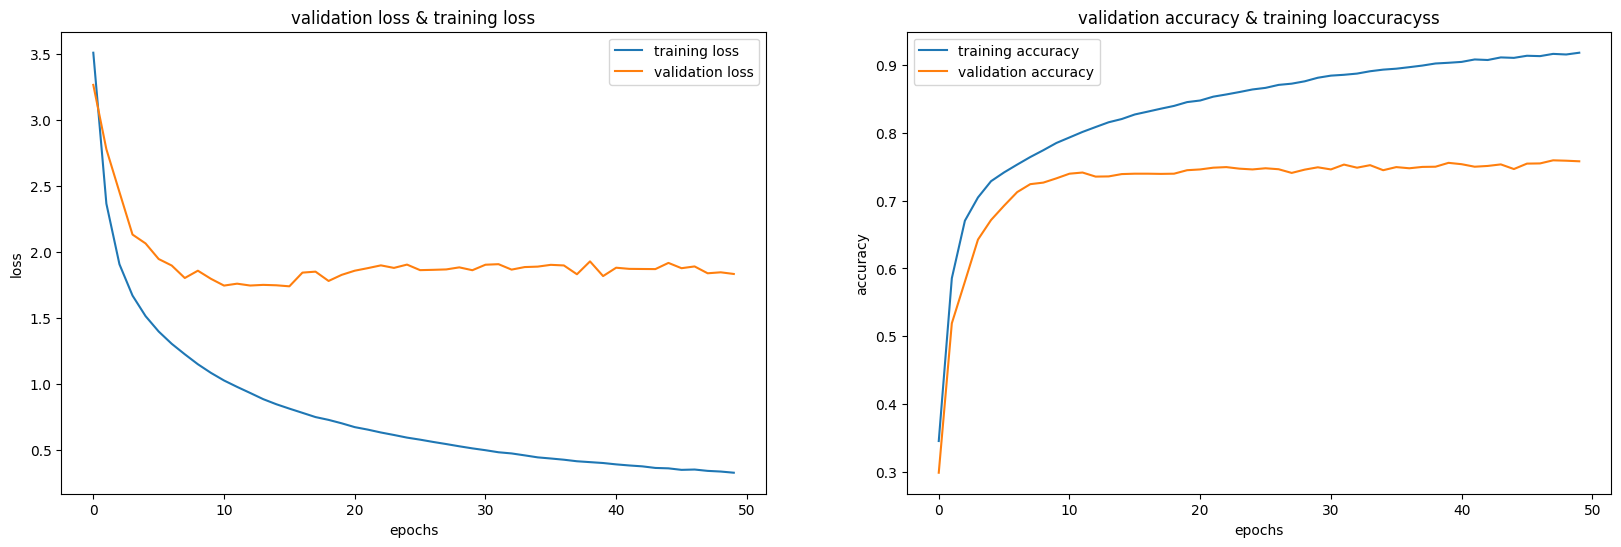

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
# Plot the first subplot  loss)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("validation loss & training loss")
plt.xlabel("epochs")
plt.ylabel("loss")
leg = plt.legend(["training loss", "validation loss"],loc ="upper right");

# Plot the second subplot ( accuracy)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("validation accuracy & training loaccuracyss")
plt.xlabel("epochs")
plt.ylabel("accuracy")
leg = plt.legend(["training accuracy", "validation accuracy"],loc ="upper left");

plt.show()


# Transformer(  Direct import transformer)

Load and prepare the data
en-fr.txt is a subset of a larger file containing more than 190,000 phrases and their corresponding translations compiled as part of the Tatoeba project. The file is tab-delimited. Each line contains an English phrase, the equivalent French phrase, and an attribution identifying where the translation came from. We don’t need the attributions, so load the dataset into a Pandas DataFrame, remove the attribution column, and shuffle and reindex the rows.

In [104]:
data.head()

,en,fr,not_needed
0,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,En route !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Bouge !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Hi.,Salut.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [105]:
data.columns = ["en", "fr","not_needed"]
data.head(5)

,en,fr,not_needed
0,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,En route !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Bouge !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Hi.,Salut.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [106]:
df = data.iloc[:10000, [0, 1]]

In [107]:
import re
from unicodedata import normalize

def clean_text(text):
    text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

def clean_and_prepare_text(text):
    text = '[start] ' + clean_text(text) + ' [end]'
    return text

df['en'] = df['en'].apply(lambda row: clean_text(row))
df['fr'] = df['fr'].apply(lambda row: clean_and_prepare_text(row))
df.head()

,en,fr
0,go,[start] marche [end]
1,go,[start] en route [end]
2,go,[start] bouge [end]
3,hi,[start] salut [end]
4,hi,[start] salut [end]


In [108]:
en = df['en']
fr = df['fr']

en_max_len = max(len(line.split()) for line in en)
fr_max_len = max(len(line.split()) for line in fr)
sequence_len = max(en_max_len, fr_max_len)

print(f'Max phrase length (English): {en_max_len}')
print(f'Max phrase length (French): {fr_max_len}')
print(f'Sequence length: {sequence_len}')

Max phrase length (English): 4
Max phrase length (French): 12
Sequence length: 12


In [109]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(en)
en_sequences = en_tokenizer.texts_to_sequences(en)
en_x = pad_sequences(en_sequences, maxlen=sequence_len, padding='post')

fr_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n')
fr_tokenizer.fit_on_texts(fr)
fr_sequences = fr_tokenizer.texts_to_sequences(fr)
fr_y = pad_sequences(fr_sequences, maxlen=sequence_len + 1, padding='post')

In [110]:
en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print(f'Vocabulary size (English): {en_vocab_size}')
print(f'Vocabulary size (French): {fr_vocab_size}')

Vocabulary size (English): 2016
Vocabulary size (French): 4236


Finally, create the features and the labels the model will be trained with. The features are the padded English sequences and the padded French sequences minus the [end] tokens. The labels are the padded French sequences minus the [start] tokens. Package the features in a dictionary so they can be input to a model that accepts multiple inputs.

In [111]:
inputs = { 'encoder_input': en_x, 'decoder_input': fr_y[:, :-1] }
outputs = fr_y[:, 1:]

# Build and train a model

Now use Keras's functional API to define a model that includes a transformer encoder and a transformer decoder. The model accepts two inputs: padded English sequences for the encoder, and padded French sequences for the decoder. The output from the decoder is fed to a softmax output layer for classification.

In [112]:
# !pip install keras_nlp


In [113]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from keras_nlp.layers import TokenAndPositionEmbedding, TransformerEncoder
from keras_nlp.layers import TransformerDecoder

np.random.seed(42)
tf.random.set_seed(42)

num_heads = 8
embed_dim = 256

encoder_input = Input(shape=(None,), dtype='int64', name='encoder_input')
x = TokenAndPositionEmbedding(en_vocab_size, sequence_len, embed_dim)(encoder_input)
encoder_output = TransformerEncoder(embed_dim, num_heads)(x)
encoded_seq_input = Input(shape=(None, embed_dim))

decoder_input = Input(shape=(None,), dtype='int64', name='decoder_input')
x = TokenAndPositionEmbedding(fr_vocab_size, sequence_len, embed_dim, mask_zero=True)(decoder_input)
x = TransformerDecoder(embed_dim, num_heads)(x, encoded_seq_input)
x = Dropout(0.4)(x)

decoder_output = Dense(fr_vocab_size, activation='softmax')(x)
decoder = Model([decoder_input, encoded_seq_input], decoder_output)
decoder_output = decoder([decoder_input, encoder_output])

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary(line_length=120)

Model: "model_10"
________________________________________________________________________________________________________________________
 Layer (type)                       Output Shape                        Param #     Connected to                        
 encoder_input (InputLayer)         [(None, None)]                      0           []                                  
                                                                                                                        
 token_and_position_embedding_4 (T  (None, None, 256)                   519168      ['encoder_input[0][0]']             
 okenAndPositionEmbedding)                                                                                              
                                                                                                                        
 decoder_input (InputLayer)         [(None, None)]                      0           []                                  
              

In [114]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
hist = model.fit(inputs, outputs, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
250/250 [==============================] - 30s 108ms/step - loss: 3.5737 - accuracy: 0.5026 - val_loss: 3.0616 - val_accuracy: 0.5631
Epoch 2/50
250/250 [==============================] - 26s 105ms/step - loss: 2.4168 - accuracy: 0.6050 - val_loss: 2.7587 - val_accuracy: 0.5937
Epoch 3/50
250/250 [==============================] - 27s 109ms/step - loss: 1.8333 - accuracy: 0.6648 - val_loss: 2.6175 - val_accuracy: 0.6285
Epoch 4/50
250/250 [==============================] - 26s 105ms/step - loss: 1.4257 - accuracy: 0.7136 - val_loss: 2.5239 - val_accuracy: 0.6438
Epoch 5/50
250/250 [==============================] - 26s 105ms/step - loss: 1.1508 - accuracy: 0.7455 - val_loss: 2.4854 - val_accuracy: 0.6461
Epoch 6/50
250/250 [==============================] - 26s 104ms/step - loss: 0.9655 - accuracy: 0.7697 - val_loss: 2.5215 - val_accuracy: 0.6527
Epoch 7/50
250/250 [==============================] - 26s 104ms/step - loss: 0.8245 - accuracy: 0.7912 - val_loss: 2.5751 - val_ac

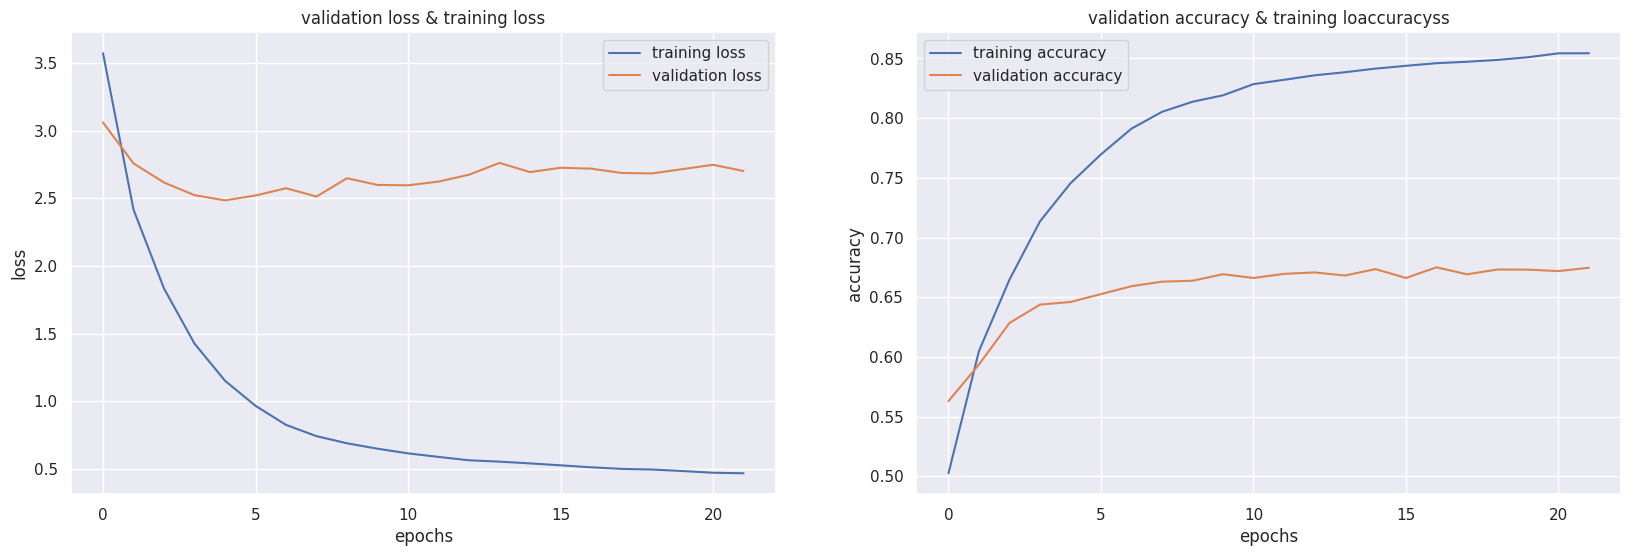

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
# Plot the first subplot  loss)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("validation loss & training loss")
plt.xlabel("epochs")
plt.ylabel("loss")
leg = plt.legend(["training loss", "validation loss"],loc ="upper right");

# Plot the second subplot ( accuracy)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("validation accuracy & training loaccuracyss")
plt.xlabel("epochs")
plt.ylabel("accuracy")
leg = plt.legend(["training accuracy", "validation accuracy"],loc ="upper left");

plt.show()


## Use the model to translate text

In [119]:
def translate_text(text, model, en_tokenizer, fr_tokenizer, fr_index_lookup, sequence_len):
    input_sequence = en_tokenizer.texts_to_sequences([text])
    padded_input_sequence = pad_sequences(input_sequence, maxlen=sequence_len, padding='post')
    decoded_text = '[start]'

    for i in range(sequence_len):
        target_sequence = fr_tokenizer.texts_to_sequences([decoded_text])
        padded_target_sequence = pad_sequences(target_sequence, maxlen=sequence_len, padding='post')[:, :-1]

        prediction = model([padded_input_sequence, padded_target_sequence])

        idx = np.argmax(prediction[0, i, :]) - 1
        token = fr_index_lookup[idx]
        decoded_text += ' ' + token

        if token == '[end]':
            break

    return decoded_text[8:-6] # Remove [start] and [end] tokens

fr_vocab = fr_tokenizer.word_index
fr_index_lookup = dict(zip(range(len(fr_vocab)), fr_vocab))
texts = en[40000:40010].values

for text in texts:
    translated = translate_text(text, model, en_tokenizer, fr_tokenizer, fr_index_lookup, sequence_len)
    print(f'{text} => {translated}')

In [123]:
translate_text('god is god', model, en_tokenizer, fr_tokenizer, fr_index_lookup, sequence_len)


'dieu le dieu'

The model isn't perfect, but it's not bad, either. The dataset that you trained with contains just 50,000 samples, but if you trained with millions of samples, you'd have the makings of a decent NMT model.